In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_features = pd.read_csv('data/training_set_features.csv', index_col='respondent_id')
train_labels = pd.read_csv('data/training_set_labels.csv', index_col='respondent_id')
test_features = pd.read_csv('data/test_set_features.csv', index_col='respondent_id')

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from category_encoders import OrdinalEncoder
import xgboost as xgb

In [4]:
num_cols = train_features.select_dtypes("number").columns

cat_cols = [
    "race",
    "sex",
    "marital_status",
    "rent_or_own",
    "hhs_geo_region",
    "census_msa",
    "employment_industry",
    "employment_occupation",
]

ord_cols = ["age_group", "education", "income_poverty", "employment_status"]

assert len(num_cols) + len(cat_cols) + len(ord_cols) == train_features.shape[1]

In [5]:
def apply_preprocessor(preprocessor: ColumnTransformer, one_hot: bool):
    train_features_transformed = preprocessor.fit_transform(train_features)
    test_features_transformed = preprocessor.fit_transform(test_features)

    # Get feature names for transformed data
    if one_hot:
        cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_cols)
    else:
        cat_feature_names = np.array(cat_cols)
    ord_feature_names = np.array(ord_cols)

    # Combine all feature names into a single list
    all_feature_names = np.concatenate((num_cols, cat_feature_names, ord_feature_names))

    train_features_transformed_df = pd.DataFrame(train_features_transformed, columns=all_feature_names)
    test_features_transformed_df = pd.DataFrame(test_features_transformed, columns=all_feature_names)
    
    return train_features_transformed_df, test_features_transformed_df

In [6]:
def prepare_data_for_xgboost():
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
        ('scaler', MinMaxScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    ordinal_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('ordinal', OrdinalEncoder())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_cols),
            ('cat', categorical_transformer, cat_cols),
            ('ord', ordinal_transformer, ord_cols)
        ]
    )
    
    return apply_preprocessor(preprocessor, True)

In [7]:
train_features_xgboost, test_features_xgboost = prepare_data_for_xgboost()
X_train_xgboost, X_test_xgboost, y_train, y_test = train_test_split(
    train_features_xgboost,
    train_labels,
    test_size=0.4,
    shuffle=True,
    random_state=314
)
X_train_xgboost

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv,age_group,education,income_poverty,employment_status
19046,0.25,1.000000,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,2.0,2.0
12518,0.50,0.666667,0.5,1.0,0.5,0.5,0.5,0.5,0.5,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0,4.0,2.0
17641,0.75,0.666667,0.5,1.0,0.5,1.0,1.0,1.0,0.5,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,1.0,3.0
10337,0.75,0.333333,0.5,1.0,0.5,1.0,0.5,0.5,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,2.0
5775,0.50,0.666667,0.5,0.5,0.5,1.0,0.5,0.5,1.0,0.5,...,0.0,0.0,0.0,0.0,1.0,0.0,5.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11094,0.75,0.666667,0.5,1.0,0.5,1.0,0.5,0.5,0.5,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,2.0
10163,0.50,0.666667,0.5,0.5,0.5,1.0,0.5,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,2.0,1.0
11977,0.25,1.000000,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0
9837,1.00,1.000000,1.0,1.0,0.5,1.0,0.5,0.5,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,3.0,2.0


In [8]:
def prepare_data_for_catboost():
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ])

    ordinal_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('ordinal', OrdinalEncoder())
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_cols),
            ('cat', categorical_transformer, cat_cols),
            ('ord', ordinal_transformer, ord_cols)
        ]
    )
    
    return apply_preprocessor(preprocessor, False)

In [9]:
train_features_catboost, test_features_catboost = prepare_data_for_catboost()
X_train_catboost, X_test_catboost, y_train, y_test = train_test_split(
    train_features_catboost,
    train_labels,
    test_size=0.4,
    shuffle=True,
    random_state=314
)
X_train_catboost

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,marital_status,rent_or_own,hhs_geo_region,census_msa,employment_industry,employment_occupation,age_group,education,income_poverty,employment_status
19046,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Not Married,Rent,qufhixun,"MSA, Principle City",wxleyezf,emcorrxb,3,3,2,2
12518,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Married,Own,qufhixun,"MSA, Principle City",xicduogh,missing,5,2,4,2
17641,2.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,Not Married,Rent,bhuqouqj,"MSA, Principle City",missing,missing,5,3,1,3
10337,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,-1.0,...,Not Married,Own,lrircsnp,"MSA, Not Principle City",ldnlellj,mxkfnird,1,2,2,2
5775,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,Married,Own,qufhixun,"MSA, Not Principle City",atmlpfrs,xtkaffoo,5,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11094,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,Not Married,Rent,qufhixun,"MSA, Not Principle City",vjjrobsf,rcertsgn,3,1,1,2
10163,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,-1.0,...,Not Married,Rent,lrircsnp,"MSA, Principle City",missing,missing,4,3,2,1
11977,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Not Married,Rent,lrircsnp,"MSA, Principle City",mcubkhph,vlluhbov,1,1,2,2
9837,3.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,Married,Own,bhuqouqj,"MSA, Not Principle City",fcxhlnwr,cmhcxjea,5,3,3,2


In [10]:
from typing import Literal, Any, Dict
from dataclasses import dataclass
from catboost import CatBoostClassifier


@dataclass
class TrainResult:
    model: Any
    scores: np.ndarray
    probabilities: np.ndarray
    y_test_target: pd.DataFrame


def train_model(target: Literal['h1n1_vaccine', 'seasonal_vaccine'], model_type: Literal['xgboost', 'catboost'], use_whole_dataset: bool = False, params: Dict = None) -> TrainResult:
    y_train_target = y_train[[target]]
    y_test_target = y_test[[target]]

    if model_type == 'xgboost':
        model = get_xgboost(params)
        X_train = X_train_xgboost
        X_test = X_test_xgboost
    if model_type == 'catboost':
        model = get_catboost(params)
        X_train = X_train_catboost
        X_test = X_test_catboost


    if use_whole_dataset:
        if model_type == 'xgboost':
            X_train = train_features_xgboost
        if model_type == 'catboost':
            X_train = train_features_catboost
        
        X_test = X_train
        y_train_target = train_labels[[target]]
        y_test_target = y_train_target

    # Fit the model on the entire training set
    model.fit(X_train, y_train_target)

    # Predict probabilities for the TEST set
    y_probabilities = model.predict_proba(X_test)[:, 1]

    # Predict scores for TEST set
    y_predictions = model.predict(X_test)

    return TrainResult(
        model=model,
        scores=y_predictions,
        probabilities=y_probabilities,
        y_test_target=y_test_target
    )

def get_xgboost(params: Dict = None):
    if params is None:
        params = {
            'colsample_bytree': 0.6,
            'learning_rate': 0.01,
            'max_depth': 5,
            'n_estimators': 1000,
            'subsample': 0.3
        }

    return xgb.XGBClassifier(**params)

def get_catboost(params: Dict = None):
    if params is None:
        params = {
            'n_estimators': 1000,
            'max_depth': 5
        }

    return CatBoostClassifier(
        logging_level='Silent',
        cat_features=cat_cols,
        # task_type='GPU',
        # devices="'1'",
        **params
    )

In [11]:
from sklearn.metrics import roc_curve, auc


def process_result(result_h1n1: TrainResult, result_seasonal: TrainResult, model_type: Literal['xgboost', 'catboost'], axe: Any):
    fpr_h1n1, tpr_h1n1, _ = roc_curve(result_h1n1.y_test_target, result_h1n1.probabilities)
    fpr_seasonal, tpr_seasonal, _ = roc_curve(result_seasonal.y_test_target, result_seasonal.probabilities)
    
    roc_auc_h1n1 = auc(fpr_h1n1, tpr_h1n1)
    roc_auc_seasonal = auc(fpr_seasonal, tpr_seasonal)

    axe.plot(fpr_h1n1, tpr_h1n1, color='blue', label=f'H1N1 (AUC = {roc_auc_h1n1:.4f})')
    axe.plot(fpr_seasonal, tpr_seasonal, color='red', label=f'Seasonal (AUC = {roc_auc_seasonal:.4f})')
    axe.plot([0, 1], [0, 1], color='gray', linestyle='--')
    axe.set_xlabel('False Positive Rate')
    axe.set_ylabel('True Positive Rate')
    axe.set_title(f'ROC Curve for {model_type}')
    axe.legend(loc='lower right')
    axe.grid(True)
    
    return np.average([roc_auc_h1n1, roc_auc_seasonal])

In [12]:
def process_model(model_type: Literal['xgboost', 'catboost'], axe: Any, params: Dict = None) -> Any:
    result_h1n1 = train_model(
        target='h1n1_vaccine',
        model_type=model_type
    )
    result_seasonal = train_model(
        target='seasonal_vaccine',
        model_type=model_type
    )
    roc_auc = process_result(result_h1n1, result_seasonal, model_type, axe)
    
    print(f'Mean ROC AUC ({model_type}) = {roc_auc:.4f}')
    
    return {
        'h1n1_vaccine': result_h1n1.model,
        'seasonal_vaccine': result_seasonal.model
    }

Mean ROC AUC (xgboost) = 0.8650
Mean ROC AUC (catboost) = 0.8637


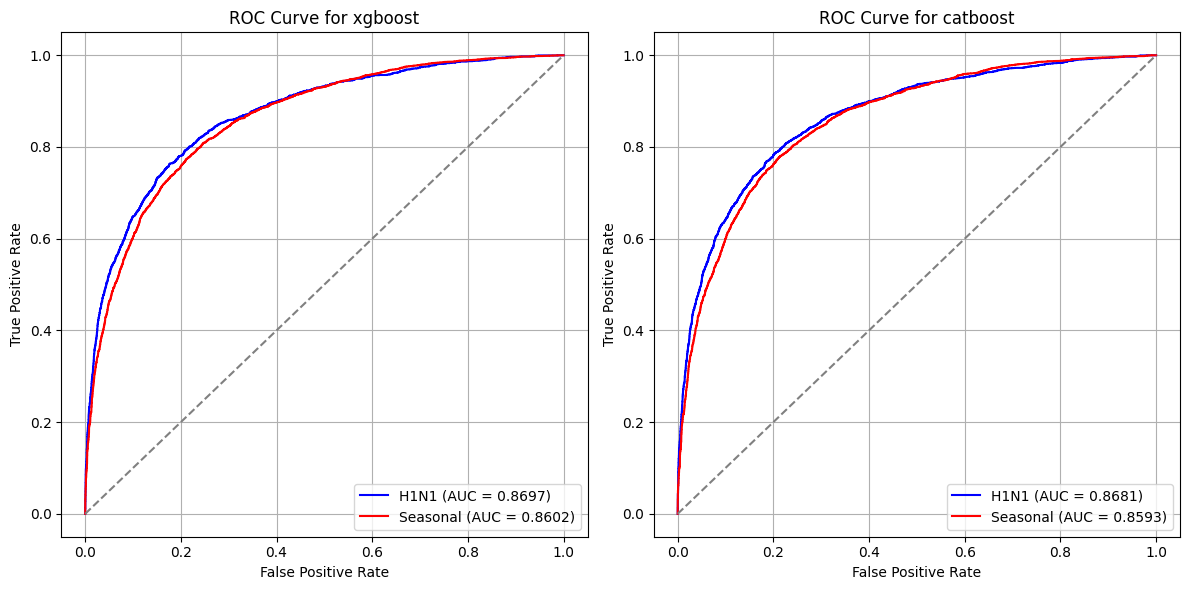

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

models_xgboost = process_model('xgboost', axes[0])
models_catboost = process_model('catboost', axes[1])

plt.tight_layout()
plt.show()

## Feature Selection

In [14]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs


def select_features(model, data, target: Literal['h1n1_vaccine', 'seasonal_vaccine'], ct = None):
    sfs = SFS(
        estimator=model, 
        k_features='best', 
        forward=True, 
        floating=False, 
        verbose=2,
        scoring='roc_auc',
        cv=5,
        n_jobs=-1
    )

    if ct is not None:
        data = ct.fit_transform(data)
    
    sfs = sfs.fit(data, np.array(y_train[target]).ravel())
    
    sfdf = pd.DataFrame(sfs.get_metric_dict()).T
    
    print(sfdf.loc[18, 'feature_idx'])
    plot_sfs(sfs.get_metric_dict(), kind='std_err', figsize=(15,6))

    plt.title('ROC AUC with features number')
    plt.grid()
    plt.show()
    
    return sfdf

### CatBoost H1N1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.


[Parallel(n_jobs=-1)]: Done  12 out of  35 | elapsed:    8.7s remaining:   16.7s
[Parallel(n_jobs=-1)]: Done  30 out of  35 | elapsed:   11.0s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   11.4s finished

[2024-10-24 03:40:14] Features: 1/35 -- score: 0.7004752319456309[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  34 | elapsed:    7.0s remaining:   14.7s
[Parallel(n_jobs=-1)]: Done  29 out of  34 | elapsed:    9.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:    9.1s finished

[2024-10-24 03:40:23] Features: 2/35 -- score: 0.7893181040252959[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  33 | elapsed:    4.1s remaining:   18.4s
[Parallel(n_jobs=-1)]: Done  23 out of  33 | elapsed:    8.3s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    9.6s finished

[2024-10-24 03

(0, 1, 3, 6, 8, 12, 13, 14, 15, 21, 22, 25, 26, 27, 28, 29, 31, 32)


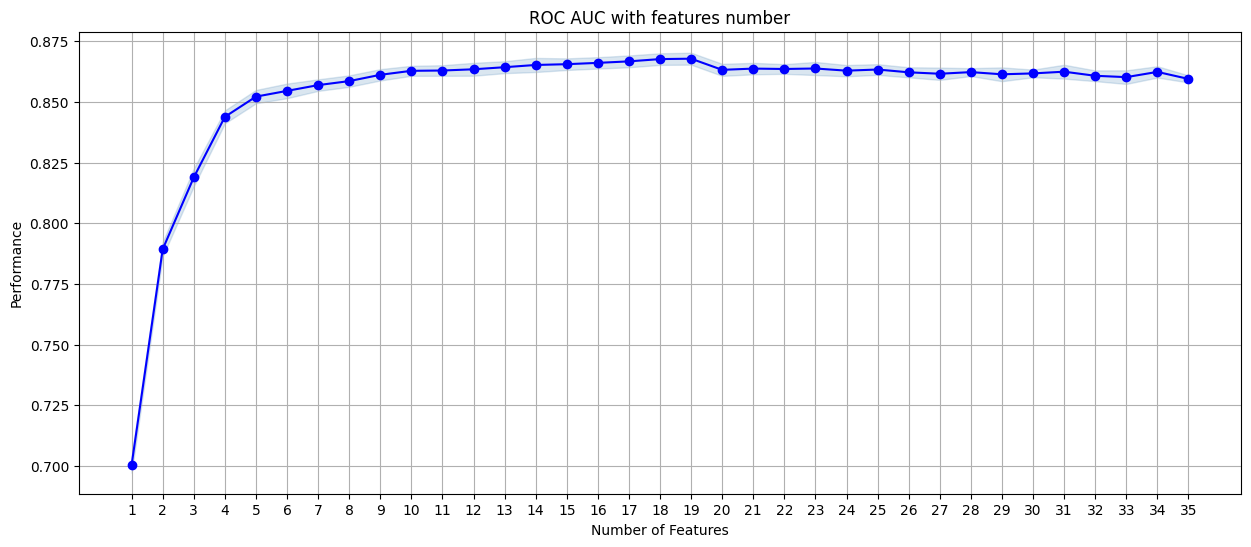

(0, 1, 3, 6, 8, 9, 12, 13, 14, 15, 21, 22, 25, 26, 27, 28, 29, 31, 32)


['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_avoidance',
 'behavioral_large_gatherings',
 'behavioral_touch_face',
 'doctor_recc_h1n1',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'opinion_h1n1_vacc_effective',
 'household_adults',
 'household_children',
 'marital_status',
 'rent_or_own',
 'hhs_geo_region',
 'census_msa',
 'employment_industry',
 'age_group',
 'education']

In [15]:
params_catboost_h1n1 = {
    'n_estimators': 100,
    'verbose': False,
}

ct = ColumnTransformer(
    [('ordinal', OrdinalEncoder(), cat_cols + ord_cols)],
    remainder='passthrough'
)

sfs_model_catboost_h1n1 = CatBoostClassifier(**params_catboost_h1n1)
sfdf_catboost_h1n1 = select_features(sfs_model_catboost_h1n1, X_train_catboost, 'h1n1_vaccine', ct=ct)
print(sfdf_catboost_h1n1.loc[19, 'feature_idx'])
selected_columns_catboost_h1n1 = [X_train_catboost.columns[i] for i in  list(sfdf_catboost_h1n1.loc[19, 'feature_idx'])]
selected_columns_catboost_h1n1


### CatBoost Seasonal

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.


[Parallel(n_jobs=-1)]: Done  12 out of  35 | elapsed:    4.0s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done  30 out of  35 | elapsed:    7.0s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    7.5s finished

[2024-10-24 03:45:29] Features: 1/35 -- score: 0.7132087052418979[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  34 | elapsed:    5.0s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done  29 out of  34 | elapsed:    9.2s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:    9.5s finished

[2024-10-24 03:45:38] Features: 2/35 -- score: 0.7750429687268088[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  33 | elapsed:    4.8s remaining:   21.6s
[Parallel(n_jobs=-1)]: Done  23 out of  33 | elapsed:    9.0s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:   10.0s finished

[2024-10-24 03

(0, 2, 6, 8, 9, 13, 20, 21, 22, 23, 25, 26, 28, 29, 30, 31, 32, 34)


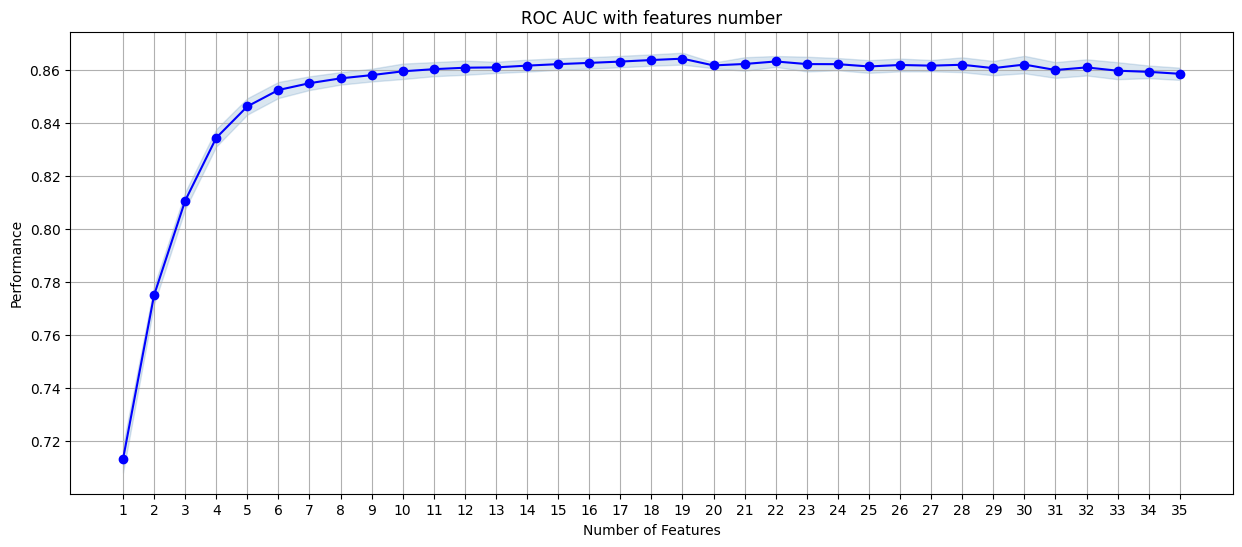

In [16]:
sfdf_catboost_seasonal = select_features(sfs_model_catboost_h1n1, X_train_catboost, 'seasonal_vaccine', ct=ct)

In [17]:
print(sfdf_catboost_seasonal.loc[18, 'feature_idx'])
selected_columns_catboost_seasonal = [X_train_catboost.columns[i] for i in  list(sfdf_catboost_seasonal.loc[19, 'feature_idx'])]
selected_columns_catboost_seasonal

(0, 2, 6, 8, 9, 13, 20, 21, 22, 23, 25, 26, 28, 29, 30, 31, 32, 34)


['h1n1_concern',
 'behavioral_antiviral_meds',
 'behavioral_large_gatherings',
 'behavioral_touch_face',
 'doctor_recc_h1n1',
 'health_worker',
 'opinion_seas_sick_from_vacc',
 'household_adults',
 'household_children',
 'race',
 'marital_status',
 'rent_or_own',
 'hhs_geo_region',
 'census_msa',
 'employment_industry',
 'employment_occupation',
 'age_group',
 'education',
 'employment_status']

In [18]:
import optuna
from catboost import Pool, cv


def get_optimal_params_catboost(target: Literal['h1n1_vaccine', 'seasonal_vaccine']) -> Dict:
    cat_features_indices = list(range(23, 23 + len(cat_cols)))
    train_dataset = Pool(
        data=X_train_catboost,
        label=y_train[target],
        cat_features=cat_features_indices
    )
    
    def objective(trial):
        param = {
            'iterations':trial.suggest_categorical('iterations', [100,200,300,500,1000,1200,1500]),
            'learning_rate':trial.suggest_float("learning_rate", 0.001, 0.3),
            'random_strength':trial.suggest_int("random_strength", 1,10),
            'bagging_temperature':trial.suggest_int("bagging_temperature", 0,10),
            'max_bin':trial.suggest_categorical('max_bin', [4,5,6,8,10,20,30]),
            'grow_policy':trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
            'min_data_in_leaf':trial.suggest_int("min_data_in_leaf", 1,10),
            'od_type' : "Iter",
            'od_wait' : 100,
            "depth": trial.suggest_int("max_depth", 2,10),
            "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-8, 100),
            'one_hot_max_size':trial.suggest_categorical('one_hot_max_size', [5,10,12,100,500,1024]),
            'custom_metric' : ['AUC'],
            "loss_function": "Logloss",
            'auto_class_weights':trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
        }

        scores = cv(train_dataset,
            param,
            fold_count=5, 
            early_stopping_rounds=10,
            plot=False, verbose=False
        )

        return scores['test-AUC-mean'].max()
    
    sampler = optuna.samplers.TPESampler(seed=68)  # Make the sampler behave in a deterministic way.
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=100)
    
    print("Number of finished trials: {}".format(len(study.trials)))
    print("Best trial:")
    trial = study.best_trial
    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}={},".format(key, value))
    
    return trial.params

/home/a-ploskin/repos/FluShot/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
# params_catboost_h1n1 = get_optimal_params_catboost(target='h1n1_vaccine')
# params_catboost_seasonal = get_optimal_params_catboost(target='seasonal_vaccine')

In [20]:
params_catboost_h1n1 = {
    'iterations': 1200,
    'learning_rate': 0.03457949514742683,
    'random_strength': 7,
    'bagging_temperature': 8,
    'max_bin': 5,
    'grow_policy': 'Lossguide',
    'min_data_in_leaf': 2,
    'max_depth': 5,
    'l2_leaf_reg': 99.11695455168572,
    'one_hot_max_size': 10,
    'auto_class_weights': 'SqrtBalanced'
}

params_catboost_seasonal = {
    'iterations': 1500,
    'learning_rate': 0.016382012566782796,
    'random_strength': 1,
    'bagging_temperature': 2,
    'max_bin': 4,
    'grow_policy': 'Depthwise',
    'min_data_in_leaf': 2,
    'max_depth': 7,
    'l2_leaf_reg': 98.28988381637733,
    'one_hot_max_size': 12,
    'auto_class_weights': 'SqrtBalanced'
}

Mean ROC AUC (catboost) = 0.8637
Mean ROC AUC (catboost optimized) = 0.8645


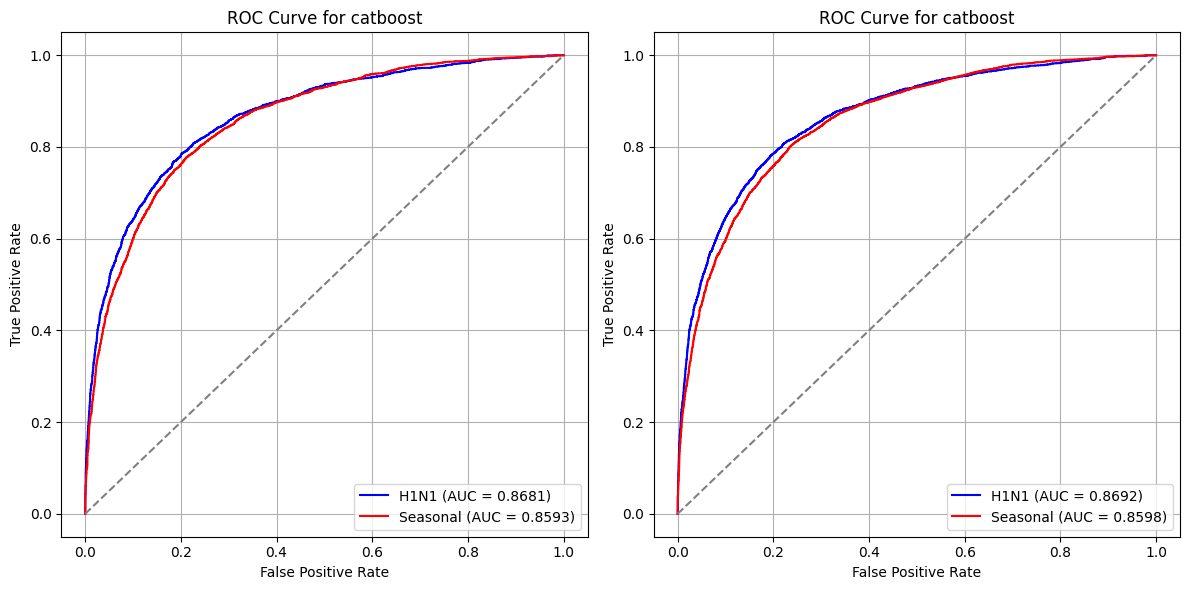

In [21]:
result_h1n1_catboost_optimal = train_model(
    target='h1n1_vaccine',
    model_type='catboost',
    params=params_catboost_h1n1
)
result_seasonal_catboost_optimal = train_model(
    target='seasonal_vaccine',
    model_type='catboost',
    params=params_catboost_seasonal
)

result_h1n1_catboost = train_model(
    target='h1n1_vaccine',
    model_type='catboost',
)
result_seasonal_catboost = train_model(
    target='seasonal_vaccine',
    model_type='catboost',
)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
roc_auc = process_result(result_h1n1_catboost, result_seasonal_catboost, 'catboost', axes[0])
roc_auc_optimal = process_result(result_h1n1_catboost_optimal, result_seasonal_catboost_optimal, 'catboost', axes[1])

print(f'Mean ROC AUC (catboost) = {roc_auc:.4f}')
print(f'Mean ROC AUC (catboost optimized) = {roc_auc_optimal:.4f}')

plt.tight_layout()
plt.show()

In [22]:
params_catboost_h1n1 = get_optimal_params_catboost(target='h1n1_vaccine')
params_catboost_seasonal = get_optimal_params_catboost(target='seasonal_vaccine')

result_h1n1_catboost_optimal = train_model(
    target='h1n1_vaccine',
    model_type='catboost'
)
result_seasonal_catboost_optimal = train_model(
    target='seasonal_vaccine',
    model_type='catboost'
)
fig, axes = plt.subplots(1, 1, figsize=(12, 6))
roc_auc = process_result(result_h1n1_catboost_optimal, result_seasonal_catboost_optimal, 'catboost', axes[0])

print(f'Mean ROC AUC ({'catboost'}) = {roc_auc:.4f}')

plt.tight_layout()
plt.show()

[I 2024-10-24 03:51:38,694] A new study created in memory with name: no-name-f5a900fd-6258-414b-a9da-7a9f9b615ee5
/tmp/ipykernel_3481787/365030429.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-8, 100),


Training on fold [0/5]



bestTest = 0.4417992543
bestIteration = 513

Training on fold [1/5]

bestTest = 0.4223749706
bestIteration = 464

Training on fold [2/5]

bestTest = 0.4300534152
bestIteration = 470

Training on fold [3/5]

bestTest = 0.4269675939
bestIteration = 545

Training on fold [4/5]


[I 2024-10-24 03:52:26,789] Trial 0 finished with value: 0.8626801308024582 and parameters: {'iterations': 1500, 'learning_rate': 0.029356482739949695, 'random_strength': 8, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 4, 'l2_leaf_reg': 0.001991194871120998, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8626801308024582.



bestTest = 0.4220845525
bestIteration = 434

Training on fold [0/5]

bestTest = 0.4386019651
bestIteration = 111

Training on fold [1/5]

bestTest = 0.4188037814
bestIteration = 105

Training on fold [2/5]

bestTest = 0.4293445316
bestIteration = 122

Training on fold [3/5]

bestTest = 0.4284245644
bestIteration = 120

Training on fold [4/5]


[I 2024-10-24 03:52:39,380] Trial 1 finished with value: 0.8633240964757235 and parameters: {'iterations': 200, 'learning_rate': 0.1464067066361795, 'random_strength': 10, 'bagging_temperature': 3, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 3, 'l2_leaf_reg': 0.028402775147703313, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 1 with value: 0.8633240964757235.



bestTest = 0.4196378082
bestIteration = 126

Training on fold [0/5]

bestTest = 0.4463979832
bestIteration = 46

Training on fold [1/5]

bestTest = 0.4246089161
bestIteration = 56

Training on fold [2/5]

bestTest = 0.4377524763
bestIteration = 51

Training on fold [3/5]

bestTest = 0.4263109286
bestIteration = 44

Training on fold [4/5]


[I 2024-10-24 03:52:51,616] Trial 2 finished with value: 0.8598492646575104 and parameters: {'iterations': 200, 'learning_rate': 0.27287829596201946, 'random_strength': 8, 'bagging_temperature': 8, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 5, 'l2_leaf_reg': 0.027330135035255495, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 1 with value: 0.8633240964757235.



bestTest = 0.4210629442
bestIteration = 46

Training on fold [0/5]

bestTest = 0.4406853884
bestIteration = 370

Training on fold [1/5]

bestTest = 0.4226867229
bestIteration = 382

Training on fold [2/5]

bestTest = 0.4310936589
bestIteration = 403

Training on fold [3/5]

bestTest = 0.426849089
bestIteration = 341

Training on fold [4/5]


[I 2024-10-24 03:53:34,464] Trial 3 finished with value: 0.8630669164151733 and parameters: {'iterations': 1200, 'learning_rate': 0.0603209284932487, 'random_strength': 3, 'bagging_temperature': 7, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 2, 'l2_leaf_reg': 1.300471404766049e-07, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 1 with value: 0.8633240964757235.



bestTest = 0.4229842414
bestIteration = 321

Training on fold [0/5]

bestTest = 0.4540071511
bestIteration = 66

Training on fold [1/5]

bestTest = 0.4186183711
bestIteration = 56

Training on fold [2/5]

bestTest = 0.4311917989
bestIteration = 55

Training on fold [3/5]

bestTest = 0.4277066539
bestIteration = 74

Training on fold [4/5]


[I 2024-10-24 03:53:40,941] Trial 4 finished with value: 0.859274999569862 and parameters: {'iterations': 300, 'learning_rate': 0.22423670437233847, 'random_strength': 6, 'bagging_temperature': 2, 'max_bin': 30, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 4, 'l2_leaf_reg': 0.00010293033487726667, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 1 with value: 0.8633240964757235.



bestTest = 0.4341490542
bestIteration = 32

Training on fold [0/5]

bestTest = 0.4994577111
bestIteration = 99

Training on fold [1/5]

bestTest = 0.4805564871
bestIteration = 99

Training on fold [2/5]

bestTest = 0.4854660354
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4828820823
bestIteration = 99

Training on fold [4/5]


[I 2024-10-24 03:53:50,532] Trial 5 finished with value: 0.8537890889790001 and parameters: {'iterations': 100, 'learning_rate': 0.06628011038512191, 'random_strength': 4, 'bagging_temperature': 4, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 2, 'l2_leaf_reg': 13.751833235431702, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 1 with value: 0.8633240964757235.



bestTest = 0.4810624905
bestIteration = 99

Training on fold [0/5]

bestTest = 0.4462804233
bestIteration = 84

Training on fold [1/5]

bestTest = 0.42094749
bestIteration = 93

Training on fold [2/5]

bestTest = 0.4366217892
bestIteration = 80

Training on fold [3/5]

bestTest = 0.425791667
bestIteration = 113

Training on fold [4/5]


[I 2024-10-24 03:55:00,605] Trial 6 finished with value: 0.8619386780200236 and parameters: {'iterations': 1200, 'learning_rate': 0.09658215406978513, 'random_strength': 8, 'bagging_temperature': 2, 'max_bin': 30, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 6, 'max_depth': 10, 'l2_leaf_reg': 2.6558249848041764, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 1 with value: 0.8633240964757235.



bestTest = 0.4190445931
bestIteration = 78

Training on fold [0/5]

bestTest = 0.4782627033
bestIteration = 74

Training on fold [1/5]

bestTest = 0.4607372155
bestIteration = 83

Training on fold [2/5]

bestTest = 0.4643738687
bestIteration = 84

Training on fold [3/5]

bestTest = 0.4591161356
bestIteration = 133

Training on fold [4/5]


[I 2024-10-24 03:55:13,090] Trial 7 finished with value: 0.8611699178284464 and parameters: {'iterations': 500, 'learning_rate': 0.2714096381817127, 'random_strength': 4, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 4.9369231964322795, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 1 with value: 0.8633240964757235.



bestTest = 0.4589546491
bestIteration = 109

Training on fold [0/5]

bestTest = 0.4485369462
bestIteration = 79

Training on fold [1/5]

bestTest = 0.4219644207
bestIteration = 81

Training on fold [2/5]

bestTest = 0.4363483704
bestIteration = 69

Training on fold [3/5]

bestTest = 0.4264045474
bestIteration = 84

Training on fold [4/5]


[I 2024-10-24 03:55:26,899] Trial 8 finished with value: 0.8600282805992855 and parameters: {'iterations': 1500, 'learning_rate': 0.2053434310118264, 'random_strength': 8, 'bagging_temperature': 0, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 3, 'l2_leaf_reg': 9.501510078266123e-06, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 1 with value: 0.8633240964757235.



bestTest = 0.4218282032
bestIteration = 67

Training on fold [0/5]

bestTest = 0.4643069821
bestIteration = 16

Training on fold [1/5]

bestTest = 0.4350435221
bestIteration = 22

Training on fold [2/5]

bestTest = 0.4466523762
bestIteration = 30

Training on fold [3/5]

bestTest = 0.4393717194
bestIteration = 26

Training on fold [4/5]


[I 2024-10-24 03:55:39,454] Trial 9 finished with value: 0.8516063960717546 and parameters: {'iterations': 100, 'learning_rate': 0.25900665720714294, 'random_strength': 3, 'bagging_temperature': 0, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 7, 'l2_leaf_reg': 1.1694576328936887e-07, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 1 with value: 0.8633240964757235.



bestTest = 0.4330315488
bestIteration = 25

Training on fold [0/5]

bestTest = 0.5146179547
bestIteration = 27

Training on fold [1/5]

bestTest = 0.4812927139
bestIteration = 58

Training on fold [2/5]

bestTest = 0.4868006307
bestIteration = 40

Training on fold [3/5]

bestTest = 0.4847470709
bestIteration = 52

Training on fold [4/5]


[I 2024-10-24 03:55:51,793] Trial 10 finished with value: 0.8463825092261867 and parameters: {'iterations': 200, 'learning_rate': 0.15034104921866256, 'random_strength': 10, 'bagging_temperature': 4, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 6, 'max_depth': 7, 'l2_leaf_reg': 0.06866979073979579, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 1 with value: 0.8633240964757235.



bestTest = 0.4707131295
bestIteration = 49

Training on fold [0/5]

bestTest = 0.4412434656
bestIteration = 151

Training on fold [1/5]

bestTest = 0.4216390142
bestIteration = 190

Training on fold [2/5]

bestTest = 0.429699294
bestIteration = 209

Training on fold [3/5]

bestTest = 0.4251724774
bestIteration = 191

Training on fold [4/5]


[I 2024-10-24 03:56:16,763] Trial 11 finished with value: 0.8631341306047047 and parameters: {'iterations': 1000, 'learning_rate': 0.12990878473982695, 'random_strength': 2, 'bagging_temperature': 7, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 2, 'l2_leaf_reg': 3.739562516929954e-08, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 1 with value: 0.8633240964757235.



bestTest = 0.4229764024
bestIteration = 163

Training on fold [0/5]

bestTest = 0.4582684578
bestIteration = 23

Training on fold [1/5]

bestTest = 0.4300486832
bestIteration = 33

Training on fold [2/5]

bestTest = 0.4358372632
bestIteration = 41

Training on fold [3/5]

bestTest = 0.4345397845
bestIteration = 34

Training on fold [4/5]


[I 2024-10-24 03:56:27,985] Trial 12 finished with value: 0.8557789376324434 and parameters: {'iterations': 1000, 'learning_rate': 0.13695845166770138, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 6, 'l2_leaf_reg': 2.484887686602939e-06, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 1 with value: 0.8633240964757235.



bestTest = 0.4340236943
bestIteration = 33

Training on fold [0/5]

bestTest = 0.4463630318
bestIteration = 40

Training on fold [1/5]

bestTest = 0.4201074344
bestIteration = 66

Training on fold [2/5]

bestTest = 0.4319210881
bestIteration = 34

Training on fold [3/5]

bestTest = 0.4265162492
bestIteration = 36

Training on fold [4/5]


[I 2024-10-24 03:56:34,538] Trial 13 finished with value: 0.8615415451554108 and parameters: {'iterations': 1000, 'learning_rate': 0.1900284225430585, 'random_strength': 1, 'bagging_temperature': 5, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 3, 'max_depth': 4, 'l2_leaf_reg': 0.0053148808004807235, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 1 with value: 0.8633240964757235.



bestTest = 0.4196059933
bestIteration = 72

Training on fold [0/5]

bestTest = 0.5040900222
bestIteration = 57

Training on fold [1/5]

bestTest = 0.4849889034
bestIteration = 45

Training on fold [2/5]

bestTest = 0.4813754279
bestIteration = 82

Training on fold [3/5]

bestTest = 0.4827996265
bestIteration = 62

Training on fold [4/5]


[I 2024-10-24 03:56:56,926] Trial 14 finished with value: 0.8501202639652853 and parameters: {'iterations': 1000, 'learning_rate': 0.12182630612300709, 'random_strength': 10, 'bagging_temperature': 3, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 10, 'l2_leaf_reg': 1.0548402867675129e-08, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 1 with value: 0.8633240964757235.



bestTest = 0.4681173188
bestIteration = 96

Training on fold [0/5]

bestTest = 0.4424115522
bestIteration = 88

Training on fold [1/5]

bestTest = 0.4209116951
bestIteration = 101

Training on fold [2/5]

bestTest = 0.4292678568
bestIteration = 131

Training on fold [3/5]

bestTest = 0.4271763319
bestIteration = 103

Training on fold [4/5]


[I 2024-10-24 03:57:14,138] Trial 15 finished with value: 0.8627826686787007 and parameters: {'iterations': 200, 'learning_rate': 0.17807845650068896, 'random_strength': 6, 'bagging_temperature': 6, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 3, 'l2_leaf_reg': 8.903621630283019e-05, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 1 with value: 0.8633240964757235.



bestTest = 0.4193357325
bestIteration = 123

Training on fold [0/5]

bestTest = 0.442205225
bestIteration = 116

Training on fold [1/5]

bestTest = 0.4179442888
bestIteration = 126

Training on fold [2/5]

bestTest = 0.4280908793
bestIteration = 122

Training on fold [3/5]

bestTest = 0.4256859954
bestIteration = 122

Training on fold [4/5]


[I 2024-10-24 03:57:28,123] Trial 16 finished with value: 0.8646921761646654 and parameters: {'iterations': 500, 'learning_rate': 0.09717541341163279, 'random_strength': 1, 'bagging_temperature': 8, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 5, 'max_depth': 3, 'l2_leaf_reg': 0.26727128990828114, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 16 with value: 0.8646921761646654.



bestTest = 0.4193240042
bestIteration = 98

Training on fold [0/5]

bestTest = 0.4433968471
bestIteration = 132

Training on fold [1/5]

bestTest = 0.4178563262
bestIteration = 134

Training on fold [2/5]

bestTest = 0.4266651034
bestIteration = 131

Training on fold [3/5]

bestTest = 0.4255187975
bestIteration = 134

Training on fold [4/5]


[I 2024-10-24 03:57:57,001] Trial 17 finished with value: 0.8638325169510704 and parameters: {'iterations': 500, 'learning_rate': 0.08956501471664485, 'random_strength': 5, 'bagging_temperature': 9, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 8, 'max_depth': 6, 'l2_leaf_reg': 0.327657902736145, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 16 with value: 0.8646921761646654.



bestTest = 0.4165811012
bestIteration = 120

Training on fold [0/5]

bestTest = 0.4945386129
bestIteration = 499

Training on fold [1/5]

bestTest = 0.4743654386
bestIteration = 499

Training on fold [2/5]

bestTest = 0.4784805628
bestIteration = 499

Training on fold [3/5]

bestTest = 0.4789333535
bestIteration = 499

Training on fold [4/5]


[I 2024-10-24 04:00:36,798] Trial 18 finished with value: 0.8608771542821885 and parameters: {'iterations': 500, 'learning_rate': 0.006962674459092724, 'random_strength': 5, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 8, 'max_depth': 8, 'l2_leaf_reg': 86.53863756625894, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 16 with value: 0.8646921761646654.



bestTest = 0.4699335741
bestIteration = 499

Training on fold [0/5]

bestTest = 0.4538785234
bestIteration = 47

Training on fold [1/5]

bestTest = 0.4241324355
bestIteration = 47

Training on fold [2/5]

bestTest = 0.4392109457
bestIteration = 49

Training on fold [3/5]

bestTest = 0.4367238173
bestIteration = 40

Training on fold [4/5]


[I 2024-10-24 04:00:55,573] Trial 19 finished with value: 0.8576044085918308 and parameters: {'iterations': 500, 'learning_rate': 0.08800761295478571, 'random_strength': 1, 'bagging_temperature': 8, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 8, 'max_depth': 8, 'l2_leaf_reg': 0.2847807586153102, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 16 with value: 0.8646921761646654.



bestTest = 0.423263907
bestIteration = 58

Training on fold [0/5]

bestTest = 0.4381404104
bestIteration = 257

Training on fold [1/5]

bestTest = 0.4157790465
bestIteration = 246

Training on fold [2/5]

bestTest = 0.427518534
bestIteration = 253

Training on fold [3/5]

bestTest = 0.4270361936
bestIteration = 264

Training on fold [4/5]


[I 2024-10-24 04:01:34,779] Trial 20 finished with value: 0.8651349009368913 and parameters: {'iterations': 500, 'learning_rate': 0.04848796734273375, 'random_strength': 5, 'bagging_temperature': 9, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 5, 'l2_leaf_reg': 0.5602699594183809, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 20 with value: 0.8651349009368913.



bestTest = 0.4179323703
bestIteration = 254

Training on fold [0/5]

bestTest = 0.4385647924
bestIteration = 233

Training on fold [1/5]

bestTest = 0.4148027495
bestIteration = 248

Training on fold [2/5]

bestTest = 0.4248928711
bestIteration = 228

Training on fold [3/5]

bestTest = 0.4245549544
bestIteration = 230

Training on fold [4/5]


[I 2024-10-24 04:02:11,663] Trial 21 finished with value: 0.8658999162209842 and parameters: {'iterations': 500, 'learning_rate': 0.05455883836462454, 'random_strength': 5, 'bagging_temperature': 9, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 5, 'l2_leaf_reg': 4.212823907703064, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 21 with value: 0.8658999162209842.



bestTest = 0.4171507523
bestIteration = 232

Training on fold [0/5]

bestTest = 0.439323745
bestIteration = 335

Training on fold [1/5]

bestTest = 0.4190625141
bestIteration = 327

Training on fold [2/5]

bestTest = 0.4278447447
bestIteration = 316

Training on fold [3/5]

bestTest = 0.4221294304
bestIteration = 353

Training on fold [4/5]


[I 2024-10-24 04:03:05,179] Trial 22 finished with value: 0.8655056536424379 and parameters: {'iterations': 500, 'learning_rate': 0.03839911035299677, 'random_strength': 7, 'bagging_temperature': 9, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 5, 'l2_leaf_reg': 0.8976925753576367, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 21 with value: 0.8658999162209842.



bestTest = 0.4145019575
bestIteration = 368

Training on fold [0/5]

bestTest = 0.4382615773
bestIteration = 424

Training on fold [1/5]

bestTest = 0.4135367315
bestIteration = 459

Training on fold [2/5]

bestTest = 0.4257222898
bestIteration = 433

Training on fold [3/5]

bestTest = 0.4245261033
bestIteration = 428

Training on fold [4/5]


[I 2024-10-24 04:04:13,342] Trial 23 finished with value: 0.8667144585930167 and parameters: {'iterations': 500, 'learning_rate': 0.033882978710036676, 'random_strength': 7, 'bagging_temperature': 9, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 5, 'l2_leaf_reg': 89.94436397893062, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 23 with value: 0.8667144585930167.



bestTest = 0.4129022237
bestIteration = 495

Training on fold [0/5]

bestTest = 0.5017540271
bestIteration = 499

Training on fold [1/5]

bestTest = 0.4911579786
bestIteration = 499

Training on fold [2/5]

bestTest = 0.495389868
bestIteration = 499

Training on fold [3/5]

bestTest = 0.4950069149
bestIteration = 499

Training on fold [4/5]


[I 2024-10-24 04:05:31,411] Trial 24 finished with value: 0.8523717072380379 and parameters: {'iterations': 500, 'learning_rate': 0.003029268024005133, 'random_strength': 7, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 9, 'max_depth': 5, 'l2_leaf_reg': 88.66898162149623, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 23 with value: 0.8667144585930167.



bestTest = 0.4904324762
bestIteration = 499

Training on fold [0/5]

bestTest = 0.4426280648
bestIteration = 299

Training on fold [1/5]

bestTest = 0.4225754973
bestIteration = 299

Training on fold [2/5]

bestTest = 0.4319914943
bestIteration = 299

Training on fold [3/5]

bestTest = 0.4298756917
bestIteration = 298

Training on fold [4/5]


[I 2024-10-24 04:06:17,400] Trial 25 finished with value: 0.863791763535741 and parameters: {'iterations': 300, 'learning_rate': 0.03241125582079515, 'random_strength': 6, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 9, 'max_depth': 5, 'l2_leaf_reg': 9.668114225690502, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 23 with value: 0.8667144585930167.



bestTest = 0.4213655155
bestIteration = 299

Training on fold [0/5]

bestTest = 0.4744341771
bestIteration = 453

Training on fold [1/5]

bestTest = 0.4488326003
bestIteration = 494

Training on fold [2/5]

bestTest = 0.4604035754
bestIteration = 438

Training on fold [3/5]

bestTest = 0.4566321775
bestIteration = 472

Training on fold [4/5]


[I 2024-10-24 04:07:46,877] Trial 26 finished with value: 0.8662541507444074 and parameters: {'iterations': 500, 'learning_rate': 0.029150821480692323, 'random_strength': 7, 'bagging_temperature': 9, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 7, 'l2_leaf_reg': 27.135189649068895, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 23 with value: 0.8667144585930167.



bestTest = 0.4473074027
bestIteration = 447

Training on fold [0/5]

bestTest = 0.4706365798
bestIteration = 209

Training on fold [1/5]

bestTest = 0.448537465
bestIteration = 215

Training on fold [2/5]

bestTest = 0.4604594597
bestIteration = 200

Training on fold [3/5]

bestTest = 0.4564548656
bestIteration = 213

Training on fold [4/5]


[I 2024-10-24 04:08:27,388] Trial 27 finished with value: 0.8659538521471767 and parameters: {'iterations': 500, 'learning_rate': 0.06571010037199063, 'random_strength': 7, 'bagging_temperature': 8, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 7, 'l2_leaf_reg': 30.15746704383919, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 23 with value: 0.8667144585930167.



bestTest = 0.4523182593
bestIteration = 221

Training on fold [0/5]

bestTest = 0.4941831159
bestIteration = 499

Training on fold [1/5]

bestTest = 0.4729141203
bestIteration = 499

Training on fold [2/5]

bestTest = 0.4790067283
bestIteration = 499

Training on fold [3/5]

bestTest = 0.4771447179
bestIteration = 499

Training on fold [4/5]


[I 2024-10-24 04:10:02,914] Trial 28 finished with value: 0.8594421298835687 and parameters: {'iterations': 500, 'learning_rate': 0.012630087638101351, 'random_strength': 9, 'bagging_temperature': 6, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 8, 'l2_leaf_reg': 32.430674323545674, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 23 with value: 0.8667144585930167.



bestTest = 0.4707335149
bestIteration = 499

Training on fold [0/5]

bestTest = 0.4942326557
bestIteration = 101

Training on fold [1/5]

bestTest = 0.4644988369
bestIteration = 152

Training on fold [2/5]

bestTest = 0.4677062001
bestIteration = 165

Training on fold [3/5]

bestTest = 0.464621416
bestIteration = 186

Training on fold [4/5]


[I 2024-10-24 04:10:35,752] Trial 29 finished with value: 0.8571063531459551 and parameters: {'iterations': 500, 'learning_rate': 0.07241905855152583, 'random_strength': 7, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 7, 'l2_leaf_reg': 0.003194611769031514, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 23 with value: 0.8667144585930167.



bestTest = 0.4614482611
bestIteration = 122

Training on fold [0/5]

bestTest = 0.4729355857
bestIteration = 519

Training on fold [1/5]

bestTest = 0.4489379923
bestIteration = 513

Training on fold [2/5]

bestTest = 0.4598744134
bestIteration = 481

Training on fold [3/5]

bestTest = 0.4549901972
bestIteration = 504

Training on fold [4/5]


[I 2024-10-24 04:12:15,253] Trial 30 finished with value: 0.866641659781157 and parameters: {'iterations': 1500, 'learning_rate': 0.02790775968437506, 'random_strength': 9, 'bagging_temperature': 8, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 9, 'l2_leaf_reg': 21.097779515300427, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 23 with value: 0.8667144585930167.



bestTest = 0.4482101941
bestIteration = 488

Training on fold [0/5]

bestTest = 0.4745366447
bestIteration = 498

Training on fold [1/5]

bestTest = 0.4489557928
bestIteration = 513

Training on fold [2/5]

bestTest = 0.4570894432
bestIteration = 507

Training on fold [3/5]

bestTest = 0.4534531362
bestIteration = 485

Training on fold [4/5]


[I 2024-10-24 04:13:49,217] Trial 31 finished with value: 0.8667730094717065 and parameters: {'iterations': 1500, 'learning_rate': 0.027831748409638223, 'random_strength': 9, 'bagging_temperature': 8, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 9, 'l2_leaf_reg': 27.110371540622914, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.8667730094717065.



bestTest = 0.4495748464
bestIteration = 491

Training on fold [0/5]

bestTest = 0.4748849052
bestIteration = 444

Training on fold [1/5]

bestTest = 0.4526523708
bestIteration = 446

Training on fold [2/5]

bestTest = 0.4621875838
bestIteration = 459

Training on fold [3/5]

bestTest = 0.4547275762
bestIteration = 459

Training on fold [4/5]


[I 2024-10-24 04:15:16,339] Trial 32 finished with value: 0.8655309227911617 and parameters: {'iterations': 1500, 'learning_rate': 0.029942488074166496, 'random_strength': 9, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 9, 'l2_leaf_reg': 2.5382038977280157, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.8667730094717065.



bestTest = 0.4505809269
bestIteration = 455

Training on fold [0/5]

bestTest = 0.4717210014
bestIteration = 638

Training on fold [1/5]

bestTest = 0.44614127
bestIteration = 768

Training on fold [2/5]

bestTest = 0.4594116053
bestIteration = 622

Training on fold [3/5]

bestTest = 0.4548887267
bestIteration = 658

Training on fold [4/5]


[I 2024-10-24 04:17:28,927] Trial 33 finished with value: 0.8670436316661005 and parameters: {'iterations': 1500, 'learning_rate': 0.022401552011750165, 'random_strength': 9, 'bagging_temperature': 7, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 9, 'l2_leaf_reg': 95.62415391999772, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 33 with value: 0.8670436316661005.



bestTest = 0.4486147321
bestIteration = 654

Training on fold [0/5]

bestTest = 0.4734345868
bestIteration = 583

Training on fold [1/5]

bestTest = 0.4487164545
bestIteration = 599

Training on fold [2/5]

bestTest = 0.4587204643
bestIteration = 571

Training on fold [3/5]

bestTest = 0.4549058633
bestIteration = 572

Training on fold [4/5]


[I 2024-10-24 04:19:22,583] Trial 34 finished with value: 0.8667026456593833 and parameters: {'iterations': 1500, 'learning_rate': 0.024848246675345027, 'random_strength': 9, 'bagging_temperature': 7, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 9, 'l2_leaf_reg': 46.671820448338295, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 33 with value: 0.8670436316661005.



bestTest = 0.4488248676
bestIteration = 551

Training on fold [0/5]

bestTest = 0.5106982094
bestIteration = 1499

Training on fold [1/5]

bestTest = 0.4954961692
bestIteration = 1499

Training on fold [2/5]

bestTest = 0.4993321866
bestIteration = 1499

Training on fold [3/5]

bestTest = 0.4980773147
bestIteration = 1499

Training on fold [4/5]


[I 2024-10-24 04:24:11,738] Trial 35 finished with value: 0.8557837041343552 and parameters: {'iterations': 1500, 'learning_rate': 0.0023143563974030515, 'random_strength': 9, 'bagging_temperature': 7, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 9, 'l2_leaf_reg': 1.6473017722682106, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 33 with value: 0.8670436316661005.



bestTest = 0.4923842039
bestIteration = 1499

Training on fold [0/5]

bestTest = 0.4928253132
bestIteration = 473

Training on fold [1/5]

bestTest = 0.4549151306
bestIteration = 751

Training on fold [2/5]

bestTest = 0.46462331
bestIteration = 700

Training on fold [3/5]

bestTest = 0.4583717603
bestIteration = 787

Training on fold [4/5]


[I 2024-10-24 04:26:16,571] Trial 36 finished with value: 0.8616328326438143 and parameters: {'iterations': 1500, 'learning_rate': 0.017818642884856357, 'random_strength': 10, 'bagging_temperature': 5, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 10, 'l2_leaf_reg': 0.0674419624108774, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 33 with value: 0.8670436316661005.



bestTest = 0.4562227232
bestIteration = 683

Training on fold [0/5]

bestTest = 0.4750500972
bestIteration = 150

Training on fold [1/5]

bestTest = 0.4481070482
bestIteration = 138

Training on fold [2/5]

bestTest = 0.4610834145
bestIteration = 127

Training on fold [3/5]

bestTest = 0.4561758193
bestIteration = 139

Training on fold [4/5]


[I 2024-10-24 04:26:44,427] Trial 37 finished with value: 0.8655328205911473 and parameters: {'iterations': 1500, 'learning_rate': 0.11019715239791718, 'random_strength': 8, 'bagging_temperature': 7, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 9, 'l2_leaf_reg': 69.33796122444642, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 33 with value: 0.8670436316661005.



bestTest = 0.4486367675
bestIteration = 125

Training on fold [0/5]

bestTest = 0.4727228101
bestIteration = 283

Training on fold [1/5]

bestTest = 0.4487456476
bestIteration = 269

Training on fold [2/5]

bestTest = 0.4610030616
bestIteration = 267

Training on fold [3/5]

bestTest = 0.4580321506
bestIteration = 267

Training on fold [4/5]


[I 2024-10-24 04:27:29,750] Trial 38 finished with value: 0.865982270742677 and parameters: {'iterations': 1500, 'learning_rate': 0.04880470914673375, 'random_strength': 9, 'bagging_temperature': 6, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 6, 'l2_leaf_reg': 7.83327693605827, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 33 with value: 0.8670436316661005.



bestTest = 0.4508190415
bestIteration = 255

Training on fold [0/5]

bestTest = 0.4899468661
bestIteration = 129

Training on fold [1/5]

bestTest = 0.4740911705
bestIteration = 112

Training on fold [2/5]


[W 2024-10-24 04:27:47,939] Trial 39 failed with parameters: {'iterations': 1200, 'learning_rate': 0.07865704870935702, 'random_strength': 8, 'bagging_temperature': 8, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 8, 'l2_leaf_reg': 0.0007154300371839268, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/home/a-ploskin/repos/FluShot/venv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_3481787/365030429.py", line 32, in objective
    scores = cv(train_dataset,
             ^^^^^^^^^^^^^^^^^
  File "/home/a-ploskin/repos/FluShot/venv/lib/python3.12/site-packages/catboost/core.py", line 6980, in cv
    return _cv(
           ^^^^
  File "_catboost.pyx", line 5880, in _catboost._cv
  File "_catboost.pyx", line 5912, in _catboost._cv

KeyboardInterrupt: 

In [ ]:
from datetime import datetime

def get_test_probabilities(model: Any) -> np.ndarray:
    return model.predict_proba(test_features_xgboost)[:, 1]

submission = pd.read_csv('data/submission_format.csv')

h1n1_model = train_model('h1n1_vaccine', 'xgboost', use_whole_dataset=True).model
seasonal_model = train_model('seasonal_vaccine', 'xgboost', use_whole_dataset=True).model

submission['h1n1_vaccine'] = get_test_probabilities(h1n1_model)
submission['seasonal_vaccine'] = get_test_probabilities(seasonal_model)

submission.to_csv(f'submission/submission_{datetime.now().isoformat(sep='_')}.csv', index=False)

submission

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,26707,0.171270,0.349341
1,26708,0.021499,0.045364
2,26709,0.162811,0.352967
3,26710,0.515226,0.869933
4,26711,0.390040,0.538098
...,...,...,...
26703,53410,0.252479,0.597809
26704,53411,0.183881,0.282557
26705,53412,0.175007,0.274644
26706,53413,0.025884,0.225328
